# Tensorflow load dataset

In [49]:
from  tensorflow.keras.utils import image_dataset_from_directory

In [53]:

class_names=['Angela','Dwight','Jim','Kevin','Michael','Pam']



images_train, images_test = image_dataset_from_directory(
                                                    directory = '../raw_data/cropped_dataset/',
                                                    batch_size=32,
                                                   labels = 'inferred',
                                                   label_mode='categorical',
#       class_names=class_names,
                                                    image_size = (100,100),
                                                    seed = 42,
                                                    validation_split = 0.2,
                                                    subset = 'both',
                                                     interpolation = 'bicubic',
                                                     crop_to_aspect_ratio = True)

Found 1091 files belonging to 6 classes.
Using 873 files for training.
Using 218 files for validation.


# images output

In [51]:
import matplotlib.pyplot as plt

/var/folders/ps/6g02fb855sldd124msj180dw0000gn/T/ipykernel_15088/4262066603.py:6: RuntimeWarning: invalid value encountered in cast
  ax.imshow(images[i].numpy().astype("uint8"))


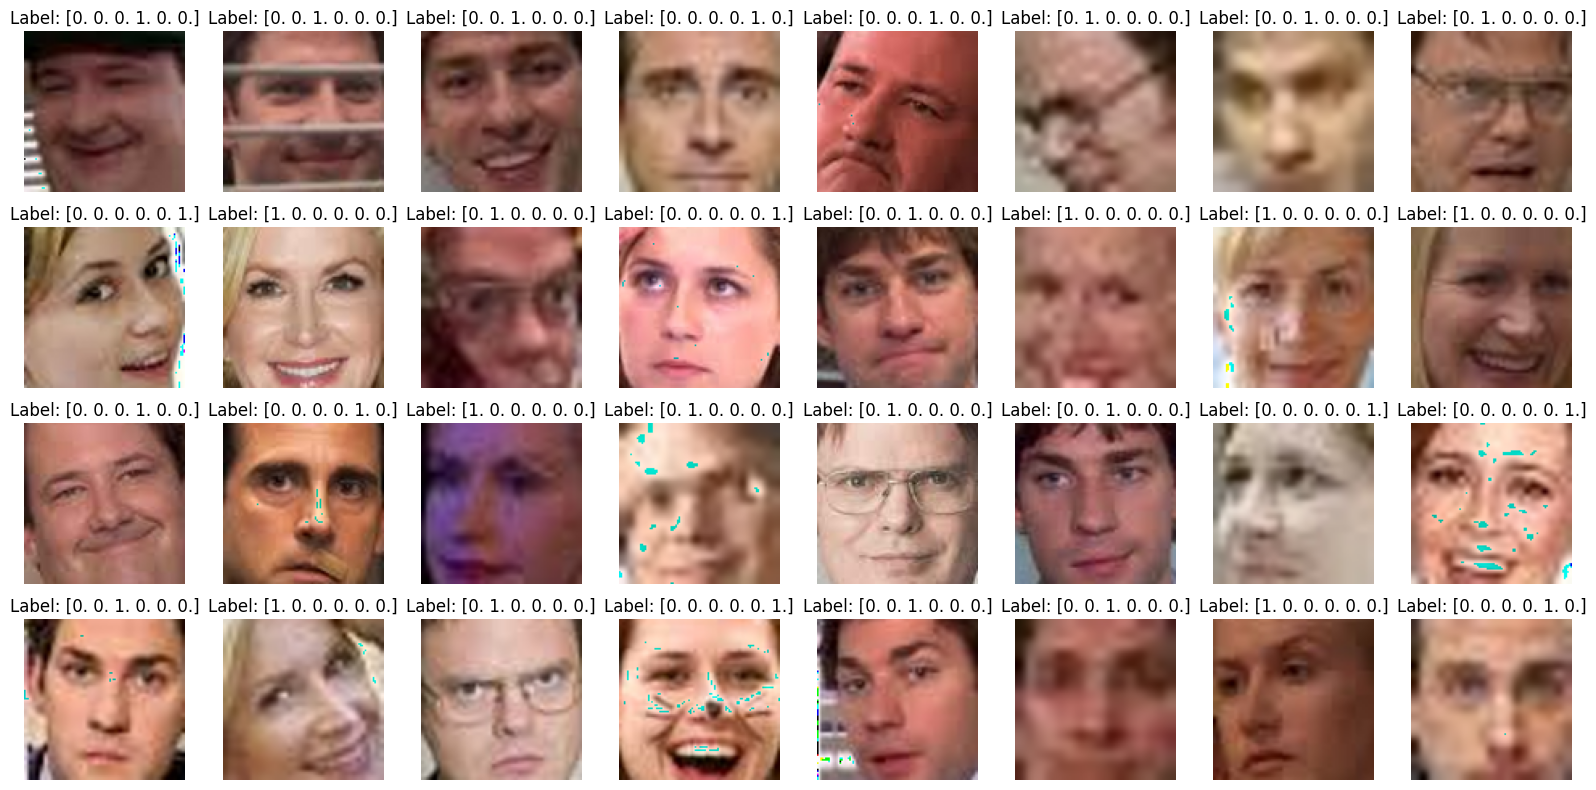

In [58]:
# Get one batch of images and labels
for images, labels in images_train.take(1):
    # Plot the images
    fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(16, 8))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(images[i].numpy().astype("uint8"))
        ax.axis('off')
        ax.set_title(f'Label: {labels[i]}')
    plt.tight_layout()
    plt.show()

# GoogleNet model

In [59]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses, Model


from tensorflow import keras
from keras import datasets

In [32]:
def inception(x,
              filters_1x1,
              filters_3x3_reduce,
              filters_3x3,
              filters_5x5_reduce,
              filters_5x5,
              filters_pool):
  path1 = layers.Conv2D(filters_1x1, (1, 1), padding='same', activation='relu')(x)

  path2 = layers.Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(x)
  path2 = layers.Conv2D(filters_3x3, (1, 1), padding='same', activation='relu')(path2)

  path3 = layers.Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu')(x)
  path3 = layers.Conv2D(filters_5x5, (1, 1), padding='same', activation='relu')(path3)

  path4 = layers.MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
  path4 = layers.Conv2D(filters_pool, (1, 1), padding='same', activation='relu')(path4)

  return tf.concat([path1, path2, path3, path4], axis=3)

In [39]:
inp = layers.Input(shape=(100, 100, 3))
input_tensor = layers.experimental.preprocessing.Resizing(224, 224, interpolation="bilinear", input_shape=images_train)(inp)

x = layers.Conv2D(64, 7, strides=2, padding='same', activation='relu')(input_tensor)
x = layers.MaxPooling2D(3, strides=2)(x)

x = layers.Conv2D(64, 1, strides=1, padding='same', activation='relu')(x)
x = layers.Conv2D(192, 3, strides=1, padding='same', activation='relu')(x)

x = layers.MaxPooling2D(3, strides=2)(x)

x = inception(x,
              filters_1x1=64,
              filters_3x3_reduce=96,
              filters_3x3=128,
              filters_5x5_reduce=16,
              filters_5x5=32,
              filters_pool=32)

x = inception(x,
              filters_1x1=128,
              filters_3x3_reduce=128,
              filters_3x3=192,
              filters_5x5_reduce=32,
              filters_5x5=96,
              filters_pool=64)

x = layers.MaxPooling2D(3, strides=2)(x)

x = inception(x,
              filters_1x1=192,
              filters_3x3_reduce=96,
              filters_3x3=208,
              filters_5x5_reduce=16,
              filters_5x5=48,
              filters_pool=64)

aux1 = layers.AveragePooling2D((5, 5), strides=3)(x)
aux1 = layers.Conv2D(128, 1, padding='same', activation='relu')(aux1)
aux1 = layers.Flatten()(aux1)
aux1 = layers.Dense(1024, activation='relu')(aux1)
aux1 = layers.Dropout(0.7)(aux1)
aux1 = layers.Dense(10, activation='softmax')(aux1)

x = inception(x,
              filters_1x1=160,
              filters_3x3_reduce=112,
              filters_3x3=224,
              filters_5x5_reduce=24,
              filters_5x5=64,
              filters_pool=64)

x = inception(x,
              filters_1x1=128,
              filters_3x3_reduce=128,
              filters_3x3=256,
              filters_5x5_reduce=24,
              filters_5x5=64,
              filters_pool=64)

x = inception(x,
              filters_1x1=112,
              filters_3x3_reduce=144,
              filters_3x3=288,
              filters_5x5_reduce=32,
              filters_5x5=64,
              filters_pool=64)

aux2 = layers.AveragePooling2D((5, 5), strides=3)(x)
aux2 = layers.Conv2D(128, 1, padding='same', activation='relu')(aux2)
aux2 = layers.Flatten()(aux2)
aux2 = layers.Dense(1024, activation='relu')(aux2)
aux2 = layers.Dropout(0.7)(aux2)
aux2 = layers.Dense(10, activation='softmax')(aux2)

x = inception(x,
              filters_1x1=256,
              filters_3x3_reduce=160,
              filters_3x3=320,
              filters_5x5_reduce=32,
              filters_5x5=128,
              filters_pool=128)

x = layers.MaxPooling2D(3, strides=2)(x)

x = inception(x,
              filters_1x1=256,
              filters_3x3_reduce=160,
              filters_3x3=320,
              filters_5x5_reduce=32,
              filters_5x5=128,
              filters_pool=128)

x = inception(x,
              filters_1x1=384,
              filters_3x3_reduce=192,
              filters_3x3=384,
              filters_5x5_reduce=48,
              filters_5x5=128,
              filters_pool=128)

x = layers.GlobalAveragePooling2D()(x)

x = layers.Dropout(0.4)(x)
out = layers.Dense(10, activation='softmax')(x)

In [40]:
model = Model(inputs = inp, outputs = [out, aux1, aux2])

In [41]:
model.compile(optimizer='adam', loss=[losses.sparse_categorical_crossentropy, losses.sparse_categorical_crossentropy, losses.sparse_categorical_crossentropy], loss_weights=[1, 0.3, 0.3], metrics=['accuracy'])

In [42]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 resizing_4 (Resizing)          (None, 224, 224, 3)  0           ['input_8[0][0]']                
                                                                                                  
 conv2d_236 (Conv2D)            (None, 112, 112, 64  9472        ['resizing_4[0][0]']             
                                )                                                                 
                                                                                            

In [43]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss',patience = 2,restore_best_weights=True)

In [60]:
history = model.fit(images_train,
                  epochs = 100,batch_size=32,
               verbose=1, validation_data=images_test,
               callbacks = [es]
              )

Epoch 1/100


InvalidArgumentError: Graph execution error:

Detected at node 'sparse_categorical_crossentropy_1/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits' defined at (most recent call last):
    File "/Users/merlemarie/.pyenv/versions/3.10.6/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Users/merlemarie/.pyenv/versions/3.10.6/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/Users/merlemarie/.pyenv/versions/3.10.6/envs/computer_vision/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/Users/merlemarie/.pyenv/versions/3.10.6/envs/computer_vision/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/Users/merlemarie/.pyenv/versions/3.10.6/envs/computer_vision/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 725, in start
      self.io_loop.start()
    File "/Users/merlemarie/.pyenv/versions/3.10.6/envs/computer_vision/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/Users/merlemarie/.pyenv/versions/3.10.6/lib/python3.10/asyncio/base_events.py", line 600, in run_forever
      self._run_once()
    File "/Users/merlemarie/.pyenv/versions/3.10.6/lib/python3.10/asyncio/base_events.py", line 1896, in _run_once
      handle._run()
    File "/Users/merlemarie/.pyenv/versions/3.10.6/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/merlemarie/.pyenv/versions/3.10.6/envs/computer_vision/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "/Users/merlemarie/.pyenv/versions/3.10.6/envs/computer_vision/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "/Users/merlemarie/.pyenv/versions/3.10.6/envs/computer_vision/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell
      await result
    File "/Users/merlemarie/.pyenv/versions/3.10.6/envs/computer_vision/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/Users/merlemarie/.pyenv/versions/3.10.6/envs/computer_vision/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/Users/merlemarie/.pyenv/versions/3.10.6/envs/computer_vision/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/Users/merlemarie/.pyenv/versions/3.10.6/envs/computer_vision/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "/Users/merlemarie/.pyenv/versions/3.10.6/envs/computer_vision/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "/Users/merlemarie/.pyenv/versions/3.10.6/envs/computer_vision/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/merlemarie/.pyenv/versions/3.10.6/envs/computer_vision/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/merlemarie/.pyenv/versions/3.10.6/envs/computer_vision/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/merlemarie/.pyenv/versions/3.10.6/envs/computer_vision/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/ps/6g02fb855sldd124msj180dw0000gn/T/ipykernel_15088/2831954396.py", line 1, in <module>
      history = model.fit(images_train,
    File "/Users/merlemarie/.pyenv/versions/3.10.6/envs/computer_vision/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/merlemarie/.pyenv/versions/3.10.6/envs/computer_vision/lib/python3.10/site-packages/keras/engine/training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "/Users/merlemarie/.pyenv/versions/3.10.6/envs/computer_vision/lib/python3.10/site-packages/keras/engine/training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "/Users/merlemarie/.pyenv/versions/3.10.6/envs/computer_vision/lib/python3.10/site-packages/keras/engine/training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/merlemarie/.pyenv/versions/3.10.6/envs/computer_vision/lib/python3.10/site-packages/keras/engine/training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "/Users/merlemarie/.pyenv/versions/3.10.6/envs/computer_vision/lib/python3.10/site-packages/keras/engine/training.py", line 994, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/Users/merlemarie/.pyenv/versions/3.10.6/envs/computer_vision/lib/python3.10/site-packages/keras/engine/training.py", line 1052, in compute_loss
      return self.compiled_loss(
    File "/Users/merlemarie/.pyenv/versions/3.10.6/envs/computer_vision/lib/python3.10/site-packages/keras/engine/compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/Users/merlemarie/.pyenv/versions/3.10.6/envs/computer_vision/lib/python3.10/site-packages/keras/losses.py", line 152, in __call__
      losses = call_fn(y_true, y_pred)
    File "/Users/merlemarie/.pyenv/versions/3.10.6/envs/computer_vision/lib/python3.10/site-packages/keras/losses.py", line 272, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/Users/merlemarie/.pyenv/versions/3.10.6/envs/computer_vision/lib/python3.10/site-packages/keras/losses.py", line 2084, in sparse_categorical_crossentropy
      return backend.sparse_categorical_crossentropy(
    File "/Users/merlemarie/.pyenv/versions/3.10.6/envs/computer_vision/lib/python3.10/site-packages/keras/backend.py", line 5630, in sparse_categorical_crossentropy
      res = tf.nn.sparse_softmax_cross_entropy_with_logits(
Node: 'sparse_categorical_crossentropy_1/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits'
logits and labels must have the same first dimension, got logits shape [32,10] and labels shape [192]
	 [[{{node sparse_categorical_crossentropy_1/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_train_function_22565]

In [ ]:

history = model.fit(x_train, [y_train, y_train, y_train], validation_data=(x_val, [y_val, y_val, y_val]), batch_size=64, epochs=40)
   

In [7]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(50, 50, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top of the pre-trained VGG16 model
model = Sequential([
    Rescaling(scale=1./255, input_shape=(100, 100, 3)),
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(130, activation='relu'),
    Dense(6, activation='softmax')
])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 130)               33410     
                                                                 
 dense_2 (Dense)             (None, 6)                 786       
                                                                 
Total params: 20,189,908
Trainable params: 165,524
Non-t

In [9]:
model.compile(loss='categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy']
             )

In [10]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss',patience = 2,restore_best_weights=True)

In [11]:
history = model.fit(images_train,
                  epochs = 100,batch_size=32,
               verbose=1, validation_data=images_test,
               callbacks = [es]
              )

Epoch 1/100
30/30 [==============================] - 143s 5s/step - loss: 11.2716 - accuracy: 0.2733 - val_loss: 3.1285 - val_accuracy: 0.4292
Epoch 2/100
30/30 [==============================] - 87s 3s/step - loss: 4.4222 - accuracy: 0.4373 - val_loss: 1.6861 - val_accuracy: 0.5408
Epoch 3/100
30/30 [==============================] - 43s 1s/step - loss: 2.5816 - accuracy: 0.5177 - val_loss: 1.4350 - val_accuracy: 0.5579
Epoch 4/100
30/30 [==============================] - 73s 2s/step - loss: 2.1074 - accuracy: 0.5584 - val_loss: 1.1876 - val_accuracy: 0.6395
Epoch 5/100
30/30 [==============================] - 52s 2s/step - loss: 1.7109 - accuracy: 0.5863 - val_loss: 1.2270 - val_accuracy: 0.6052
Epoch 6/100
30/30 [==============================] - 37s 1s/step - loss: 1.2847 - accuracy: 0.6377 - val_loss: 1.2626 - val_accuracy: 0.6094


In [ ]:
# %tensorboard --logdir logs/fit

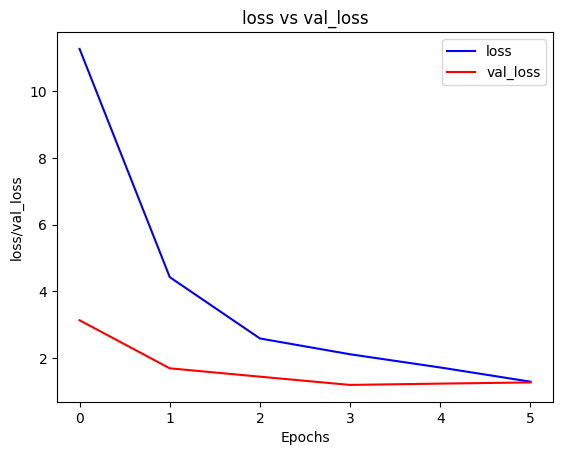

In [12]:
plt.plot(model.history.history['loss'],color='b',label='loss')
plt.plot(model.history.history['val_loss'],color='r',label='val_loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('loss/val_loss')
plt.title('loss vs val_loss')
plt.show()

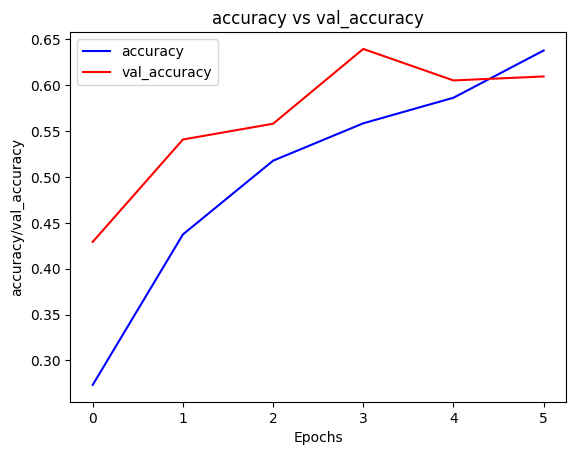

In [13]:
plt.plot(model.history.history['accuracy'],color='b',label = 'accuracy')
plt.plot(model.history.history['val_accuracy'],color='r',label = 'val_accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('accuracy/val_accuracy')
plt.title('accuracy vs val_accuracy')
plt.show()

# evaluate

In [14]:
images_test_main = image_dataset_from_directory(
                                                   directory = '../data/cast/',
                                                    labels = None,label_mode=None,
                                                    image_size = (50,50),
                                                    seed = 42,
                                                    interpolation = 'bicubic',
                                                    crop_to_aspect_ratio = True)

Found 28 files belonging to 1 classes.


InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:CPU:0}} slice index 28 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

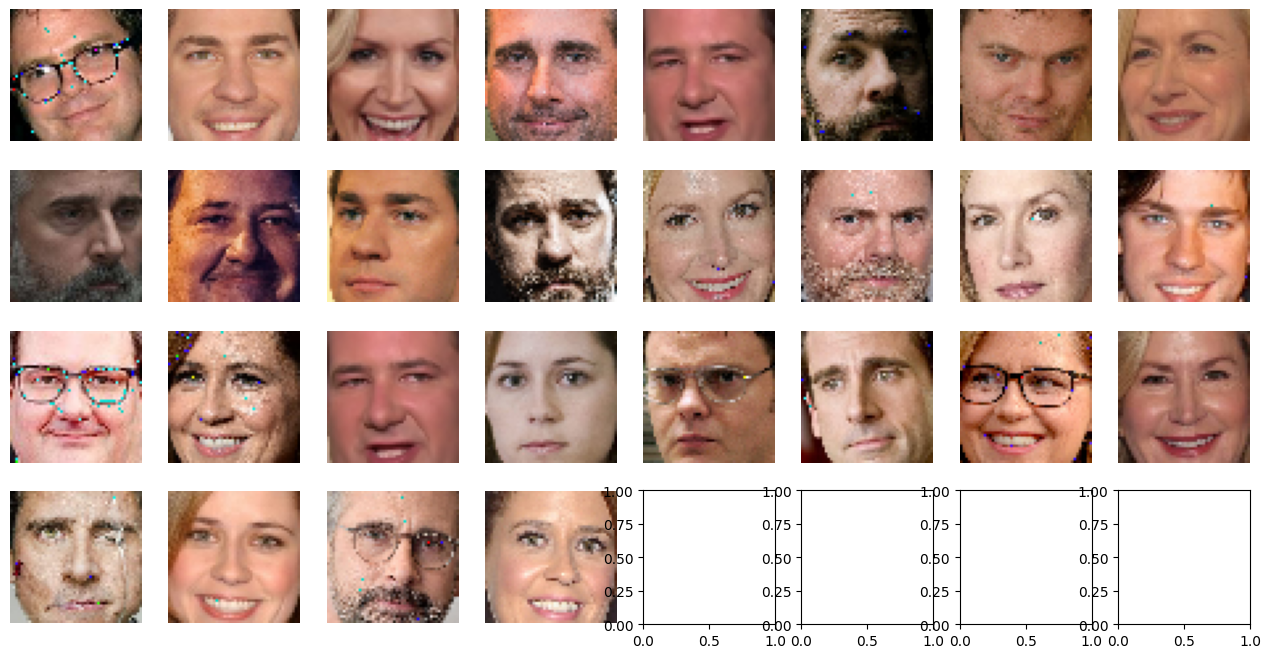

In [15]:
for images in images_test_main.take(1):
    # Plot the images
    fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(16, 8))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(images[i].numpy().astype("uint8"))
        ax.axis('off')
#         ax.set_title(f'Label: {labels[i]}')
    plt.tight_layout()
    plt.show()

In [19]:
model.evaluate(images_test
              )

8/8 [==============================] - 8s 990ms/step - loss: 1.1876 - accuracy: 0.6395


[1.1875711679458618, 0.6394850015640259]

In [16]:
result = model.predict(images_test_main)

1/1 [==============================] - 7s 7s/step


In [17]:
result.shape

(28, 6)

In [18]:
import numpy as np
lables = np.argmax(result,axis=1)
lables 

array([0, 4, 1, 3, 1, 1, 0, 4, 5, 2, 3, 1, 1, 2, 4, 2, 0, 5, 4, 3, 1, 2,
       0, 4, 4, 0, 4, 5])

InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:CPU:0}} slice index 28 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

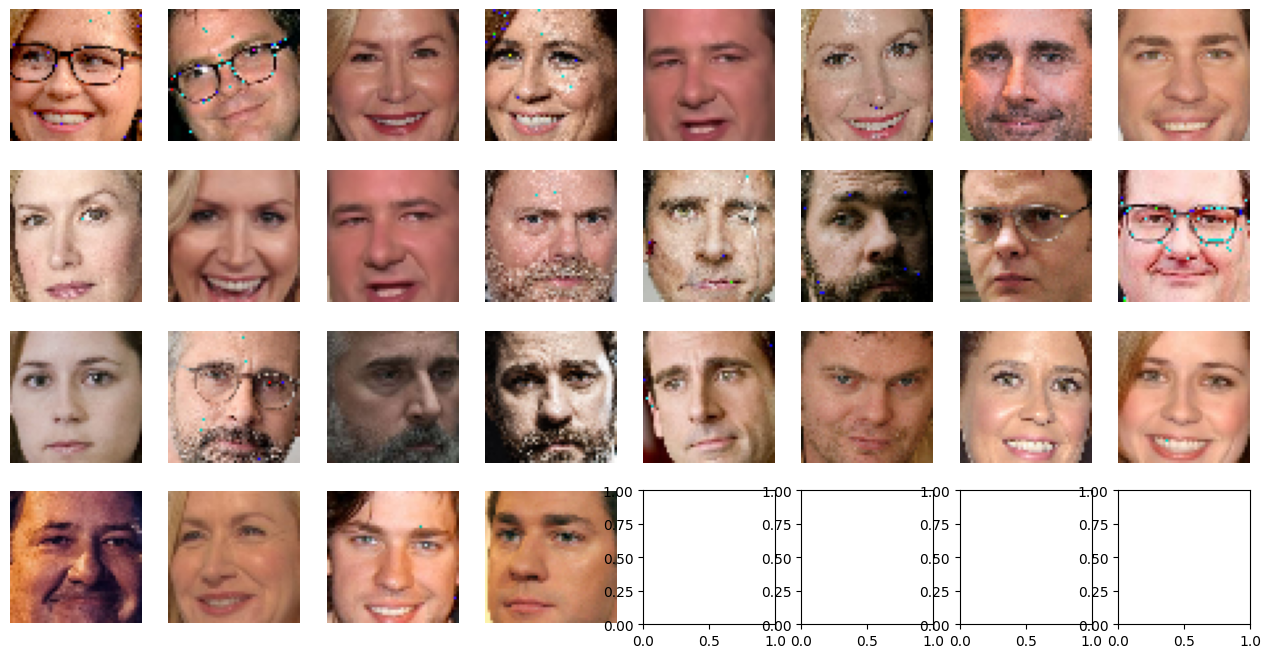

In [21]:
for images in images_test_main.take(1):
    # Plot the images
    fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(16, 8))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(images[i].numpy().astype("uint8"))
        ax.axis('off')
#         ax.set_title(f'Label: {labels[i]}')
    plt.tight_layout()
    plt.show()